In [1]:
# Code started from https://matteoacrossi.github.io/oqs-jupyterbook/project_2-solution.html

import numpy as np
from scipy.optimize import fsolve, differential_evolution

# Main qiskit imports
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.providers import Backend

# Tomography
#from qiskit.ignis.verification.tomography import state_tomography_circuits
#from qiskit.ignis.verification.tomography import StateTomographyFitter
# qiskit ignis is deprecated. Verification has been migrated to qiskit experiments
from qiskit_experiments.library import StateTomography
from qiskit_experiments.library.tomography import StateTomographyAnalysis

# Plots
import matplotlib.pyplot as plt

In [2]:
# We have an analytical solution of the system of equations
# This function hasn't changed from the refernce
def theta_from_p(p):
    """ Returns the angles [theta_1, theta_2, theta_3] that implement the Pauli channel with
    probabilities p = [p_1, p_2, p_3]"""
    
    p = np.asarray(p, dtype=complex)
    c = [np.sqrt(1 - np.sqrt(-4*p[0]**2 + (1 - 2*p[2])**2 + 8*p[0]*(p[2] + np.sqrt(-(p[2]*(-1 + 2*p[0] + p[2]))))))/np.sqrt(2),
      np.sqrt(8*p[0]**3 - 4*p[0]**2*(-1 - 6*p[2] + np.sqrt(-4*p[0]**2 + (1 - 2*p[2])**2 + 8*p[0]*(p[2] + np.sqrt(-(p[2]*(-1 + 2*p[0] + p[2])))))) + 
           (1 - 2*p[2])**2*(-1 + 2*p[2] + np.sqrt(-4*p[0]**2 + (1 - 2*p[2])**2 + 8*p[0]*(p[2] + np.sqrt(-(p[2]*(-1 + 2*p[0] + p[2])))))) - 
           2*p[0]*(1 + 4*(p[2] - 3*p[2]**2 - p[2]*np.sqrt(-4*p[0]**2 + (1 - 2*p[2])**2 + 8*p[0]*(p[2] + np.sqrt(-(p[2]*(-1 + 2*p[0] + p[2]))))) + 
                 np.sqrt(-(p[2]*(-1 + 2*p[0] + p[2])))*np.sqrt(-4*p[0]**2 + (1 - 2*p[2])**2 + 8*p[0]*(p[2] + np.sqrt(-(p[2]*(-1 + 2*p[0] + p[2]))))))))/
         (np.sqrt(2)*np.sqrt((-1 + 2*p[0] + 2*p[2])*(4*p[0]**2 + (1 - 2*p[2])**2 + p[0]*(4 + 8*p[2])))),
      np.sqrt((8*p[0]**3 - 4*p[0]**2*(-1 - 6*p[2] + np.sqrt(-4*p[0]**2 + (1 - 2*p[2])**2 + 8*p[0]*(p[2] + np.sqrt(-(p[2]*(-1 + 2*p[0] + p[2])))))) + 
             (1 - 2*p[2])**2*(-1 + 2*p[2] + np.sqrt(-4*p[0]**2 + (1 - 2*p[2])**2 + 8*p[0]*(p[2] + np.sqrt(-(p[2]*(-1 + 2*p[0] + p[2])))))) - 
             2*p[0]*(1 + 4*(p[2] - 3*p[2]**2 - p[2]*np.sqrt(-4*p[0]**2 + (1 - 2*p[2])**2 + 8*p[0]*(p[2] + np.sqrt(-(p[2]*(-1 + 2*p[0] + p[2]))))) + 
                   np.sqrt(-(p[2]*(-1 + 2*p[0] + p[2])))*np.sqrt(-4*p[0]**2 + (1 - 2*p[2])**2 + 8*p[0]*(p[2] + np.sqrt(-(p[2]*(-1 + 2*p[0] + p[2]))))))))/
           (4*p[0]**2 + (1 - 2*p[2])**2 + p[0]*(4 + 8*p[2])))/np.sqrt(-2 + 4*p[0] + 4*p[2])]

    theta = 2*np.arccos(np.real(c))
    return theta

In [3]:
def pauli_channel(qc: QuantumCircuit, p: list, system: QuantumRegister, ancillae: list):
    """
        Apply the Pauli channel to system with probabilities p
        
    Args:
    q (QuantumCircuit): The quantum circuit to make a copy of and put the depolarizing channel onto.
    system (QuantumRegister): Register of the quantum circuit to use for the system.
    ancillae (list): List of QuantumRegisters to use for the ancillary qubits.
    p (list): list of probabilities [p_1, p_2, p_3] for the Pauli channel
    
    Returns:
    A QuantumCircuit implementing the Pauli channel
    """
    # Make a copy of the circuit passed in. This circuit will have the pauli depolarizing gates added to the end and then be returned.
    dc = qc.copy()

    # Calculate the values for the thetas based on the desired probabilites
    theta = theta_from_p(p)

    # Initialize the control ancillary qubits
    dc.ry(theta[0], ancillae[0])
    dc.cx(ancillae[0], ancillae[1])
    dc.ry(theta[1], ancillae[0])
    dc.ry(theta[2], ancillae[1])

    # Apply the Pauli gates.
    dc.cx(ancillae[0], system)
    dc.cy(ancillae[1], system)

    return dc

In [4]:
from qiskit.quantum_info import entropy, partial_trace

# This function hasn't changed from the reference
def conditional_entropy(state, qubit_a, qubit_b):
    """Conditional entropy S(A|B) = S(AB) - S(B)
    
    Args:
        state: a vector or density operator
        qubit_a: 0-based index of the qubit A
        qubit_b: 0-based index of the qubit B
        
    Returns:
        int: the conditional entropy
    """
    return entropy(state) - entropy(partial_trace(state, [qubit_b]))
    
# This function hasn't changed from the reference
def extractable_work(state, system_qubit, memory_qubit, n=1):
    """Extractable work from a two-qubit state
    =
    Cfr. Eq. (3-4) Bylicka et al., Sci. Rep. 6, 27989 (2016)
    
    Args:
        qubit_a: 0-based index of the system qubit S
        qubit_b: 0-based index of the memory qubit M
    """
    return (n - conditional_entropy(state, system_qubit, memory_qubit)/np.log(2))

In [5]:
# This function hasn't changed from the reference
def p_enm(t, eta=1., omega=1.):
    """ Determine the probabilities for the eternally non-Markovian over time given an eta and omega.

    Args:
        t (float): time
        eta (float): eta
        omega (float): omega

    Returns:
        list(float): Three Probabilites for the Pauli Channel.
    """
    p = [1/4 * (1 - np.exp(-2 * t * eta)), 
         1/4 * (1 - np.exp(-2 * t * eta)),
         1/4 * (1 + np.exp(-2 * t * eta) - 2 * np.exp(-t * eta) * np.cosh(t * omega))]
    return p

# This function hasn't changed from the reference
def p_ncp(t, eta=1., omega=1.):
    """ Determine the probabilities for the non-CP-divisible map over time given an eta and omega.

    Args:
        t (float): time
        eta (float): eta
        omega (float): omega

    Returns:
        list(float): Three Probabilites for the Pauli Channel.
    """
    p = [1/4 * (1 - np.exp(-2 * t * eta)), 
         1/4 * (1 - np.exp(-2 * t * eta)),
         1/4 * (1 + np.exp(-2 * t * eta) - 2 * np.exp(-t * eta) * np.cos(t * omega))]
    return p

In [6]:
# Setting up parameters
t_values = np.linspace(0, 3, 11)

# Parameters
params_ncp = {'eta': 0.1, 'omega': 2.0}
params_enm = {'eta': 1.0, 'omega': 0.5}

# Device and fitter choices
SHOTS = 128
backend = Aer.get_backend('qasm_simulator')
fitter = 'linear_inversion'

# And the qubit assignments
q = QuantumRegister(5, name='q')
c = ClassicalRegister(2, name='c')

system = 2
memory = 4

ancillae = [0, 1]

In [7]:
# Prepare the two qubits 0 and 2 in a psi- state
# psi- state is Bell state: 1/sqrt(2) * (|10> + |01>)
prepare_two_qubit = QuantumCircuit(q)

prepare_two_qubit.x(q[memory])
prepare_two_qubit.x(q[system])
prepare_two_qubit.h(q[memory])
prepare_two_qubit.cx(q[memory], q[system]) 
prepare_two_qubit.barrier()

In [8]:
def timeEvolveNCP(t_values, eta, omega, q, starting_circ, system, memory, ancillae, backend=backend, fitter=fitter):
    """ Time evolve the passed in circuit with a Pauli channel and the passed in parameters.
    The values used for the probabilites of the Pauli gates come from the Non-CP-divisible map which is dependant on the eta and omega passed in.
    Args:
        t_values (list): Values of time to evolve over
        eta (float): eta
        omega (float): omega
        q (list): QuantumRegisters used in the circuit
        starting_circ (QuantumCircuit): The quantum circuit that will have the Pauli Channel added to.
        system (int): Index of the system qubit in the list of QuantumRegisters passed in
        memory (int): Index of the memory qubit in the list of QuantumRegisters passed in
        ancillae (list): List of indexes of the qubits to be used for probabilities of the Pauli Gates
        backend (Backend): Backend to run the experiment on.
        fitter (str): Fitter algorithm used to generate density matrix from the experiment.

    Returns:
        list: List of density matricies corresponding to the time values.
    """
    wext_ncp = []
    for t in t_values:
        circ =  pauli_channel(starting_circ, p_ncp(t, eta, omega), system, [q[i] for i in ancillae])
        tomo_experiment = StateTomography(circ, measurement_indices=[system, memory])
        results = tomo_experiment.run(backend, fitter=fitter).block_for_results()
        rho = results.analysis_results("state").value.data
        wext_ncp.append(extractable_work(rho, 1, 0))
    return wext_ncp

def timeEvolveENM(t_values, eta, omega, q, starting_circ, system, memory, ancillae, backend=backend, fitter=fitter):
    """ Time evolve the passed in circuit with a Pauli channel and the passed in parameters.
    The values used for the probabilites of the Pauli gates come from the Eternally non-Markovian map which is dependant on the eta and omega passed in.
    Args:
        t_values (list): Values of time to evolve over
        eta (float): eta
        omega (float): omega
        q (list): QuantumRegisters used in the circuit
        starting_circ (QuantumCircuit): The quantum circuit that will have the Pauli Channel added to.
        system (int): Index of the system qubit in the list of QuantumRegisters passed in
        memory (int): Index of the memory qubit in the list of QuantumRegisters passed in
        ancillae (list): List of indexes of the qubits to be used for probabilities of the Pauli Gates
        backend (Backend): Backend to run the experiment on.
        fitter (str): Fitter algorithm used to generate density matrix from the experiment.

    Returns:
        list: List of density matricies corresponding to the time values.
    """
    wext_ncp 
    wext_enm = []
    for t in t_values:
        circ =  pauli_channel(starting_circ, p_enm(t, eta, omega), system, [q[i] for i in ancillae])
        tomo_experiment = StateTomography(circ, measurement_indices=[system, memory])
        results = tomo_experiment.run(backend, fitter=fitter).block_for_results()
        rho = results.analysis_results("state").value.data
        wext_enm.append(extractable_work(rho, 1, 0))
    return wext_enm

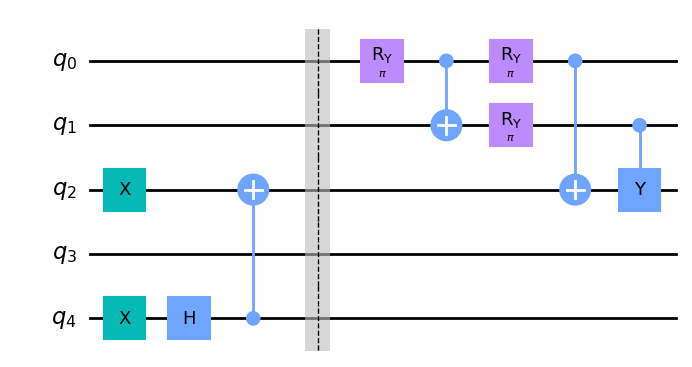

In [9]:
# Draw Circuit for reference
# The angles applied by the Ry gates are dependant on the time, eta, and omega passed in.
circ =  pauli_channel(prepare_two_qubit, p_enm(0, 0.1, 2), system, [q[i] for i in ancillae])
circ.draw('mpl')

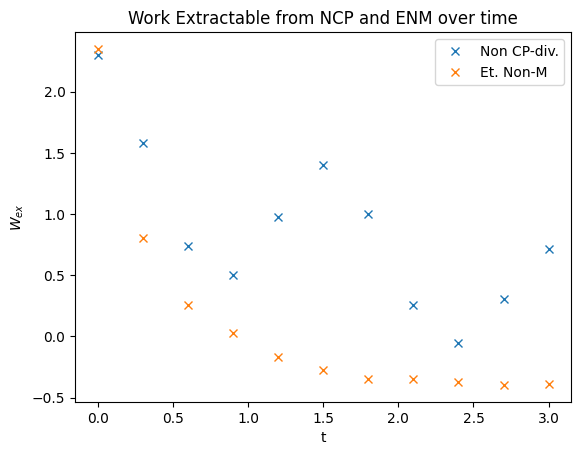

In [10]:
wext_ncp = timeEvolveNCP(t_values=t_values, **params_ncp, q=q, starting_circ=prepare_two_qubit, system=system, memory=memory, ancillae=ancillae)

wext_enm = timeEvolveENM(t_values=t_values, **params_enm, q=q, starting_circ=prepare_two_qubit, system=system, memory=memory, ancillae=ancillae)

# Plot
plt.plot(t_values, wext_ncp, 'x', label='Non CP-div.')
plt.plot(t_values, wext_enm, 'x', label='Et. Non-M')
plt.legend()
plt.title("Work Extractable from NCP and ENM over time")
plt.xlabel('t')
plt.ylabel('$W_{ex}$');

In [11]:
eta_range = np.linspace(0,1,5)

varied_etas_ncp = []
for eta in eta_range:
    varied_etas_ncp.append( timeEvolveNCP(t_values=t_values, eta=eta, omega=2, q=q, starting_circ=prepare_two_qubit, system=system, memory=memory, ancillae=ancillae))

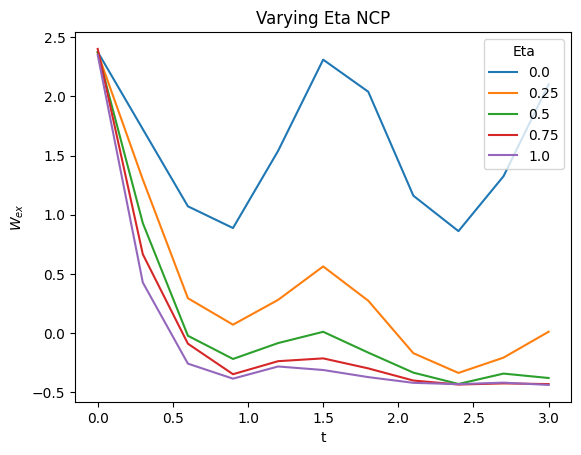

In [12]:
# Plot
for i, eta in enumerate(eta_range):
    plt.plot(t_values, varied_etas_ncp[i], "-", label=eta)
plt.legend(title="Eta")
plt.title("Varying Eta NCP")
plt.xlabel('t')
plt.ylabel('$W_{ex}$');

In [13]:
omega_range = np.linspace(0,2,5)

varied_omegas_ncp = []
for omega in omega_range:
    varied_omegas_ncp.append( timeEvolveNCP(t_values=t_values, eta=0.1, omega=omega, q=q, starting_circ=prepare_two_qubit, system=system, memory=memory, ancillae=ancillae))

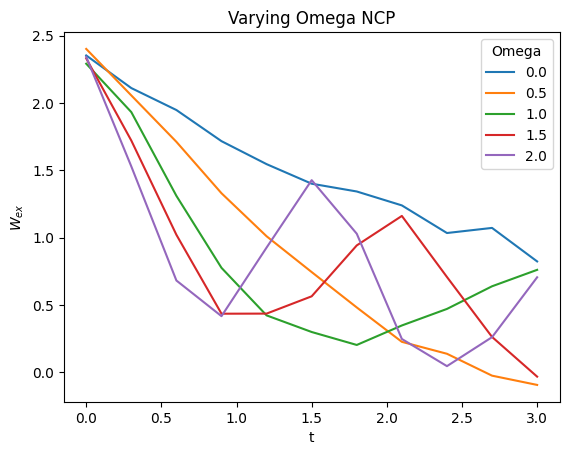

In [14]:
# Plot
for i, omega in enumerate(omega_range):
    plt.plot(t_values, varied_omegas_ncp[i], "-", label=omega)
plt.legend(title="Omega")
plt.title("Varying Omega NCP")
plt.xlabel('t')
plt.ylabel('$W_{ex}$');

In [15]:
eta_range = np.linspace(0,1,5)

varied_etas_enm = []
for eta in eta_range:
    varied_etas_enm.append( timeEvolveENM(t_values=t_values, eta=eta, omega=2, q=q, starting_circ=prepare_two_qubit, system=system, memory=memory, ancillae=ancillae))

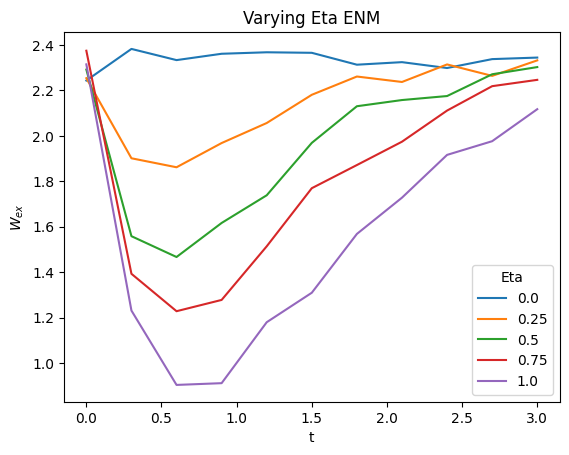

In [16]:
# Plot
for i, eta in enumerate(eta_range):
    plt.plot(t_values, varied_etas_enm[i], "-", label=eta)
plt.legend(title="Eta")
plt.title("Varying Eta ENM")
plt.xlabel('t')
plt.ylabel('$W_{ex}$');

In [17]:
omega_range = np.linspace(0,2,5)

varied_omegas_enm = []
for omega in omega_range:
    varied_omegas_enm.append( timeEvolveENM(t_values=t_values, eta=0.1, omega=omega, q=q, starting_circ=prepare_two_qubit, system=system, memory=memory, ancillae=ancillae))

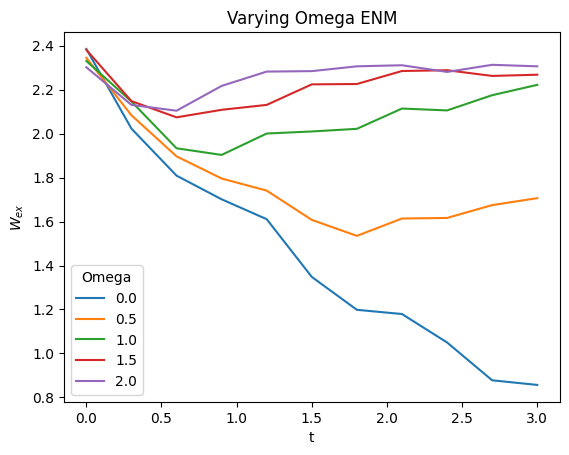

In [18]:
# Plot
for i, omega in enumerate(omega_range):
    plt.plot(t_values, varied_omegas_enm[i], "-", label=omega)
plt.legend(title="Omega")
plt.title("Varying Omega ENM")
plt.xlabel('t')
plt.ylabel('$W_{ex}$');